# SimBoost in Python


Drug discovery is a time-consuming, laborious, costly and high-risk process. According to a report by the Eastern Research Group (ERG), it usually takes 10-15 years to develop a new drug. However, the success rate of developing a new molecular entity is only 2.01%. Finding a compound that selectively binds to a particular protein is a highly challenging and typically expensive procedure in the drug development process. \
[SimBoost](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/#CR42) is a machine-learning approch for predicting drug–target binding affinities using gradient boosting.




## 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/DL4H_Spring2022/project1_simboost

/content/drive/MyDrive/DL4H_Spring2022/project1_simboost


### 1.1 Imports libs

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from collections import OrderedDict

### 1.2 Loading data

In [4]:
dataset = 'kiba' # 'kiba'

In [5]:
sim_targets = None
sim_drugs = None
bindings = None

if dataset == 'davis':
    target_gene_names = pd.read_csv(dataset+"/target_gene_names.txt", header=None, index_col = 0).index.tolist()
    drug_pubchemIDs = pd.read_csv(dataset+"/drug_PubChem_CIDs.txt", header=None, index_col = 0).index.tolist()
    print(len(drug_pubchemIDs))
    print(len(target_gene_names))
    sim_targets = pd.read_csv(dataset+"/target-target_similarities_WS_normalized.txt", names = target_gene_names, sep = ' ')
    sim_drugs = pd.read_csv(dataset+"/drug-drug_similarities_2D.txt", names = drug_pubchemIDs, sep = ' ')
    bindings = pd.read_csv(dataset+"/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt", names = target_gene_names, sep = ' ')

elif dataset == 'kiba':
    target_gene_names = list(json.load(open(dataset+"/proteins.txt"), object_pairs_hook=OrderedDict).keys())
    drug_pubchemIDs = list(json.load(open(dataset+"/ligands_can.txt"), object_pairs_hook=OrderedDict).keys())
    sim_targets = pd.read_csv(dataset+"/kiba_target_sim.txt", names = target_gene_names, sep = '\t')
    sim_drugs = pd.read_csv(dataset+"/kiba_drug_sim.txt", names = drug_pubchemIDs, sep = '\t')
    bindings = pd.read_csv(dataset+"/kiba_binding_affinity_v2.txt", names = target_gene_names, sep = '\t')


bindings.index = drug_pubchemIDs
sim_drugs.index = drug_pubchemIDs
sim_targets.index = target_gene_names
target_gene_names = pd.DataFrame(index=target_gene_names)
drug_pubchemIDs = pd.DataFrame(index=drug_pubchemIDs)
sim_targets.shape, sim_drugs.shape, bindings.shape

((229, 229), (2111, 2111), (2111, 229))

In [6]:
bindings.head()

,O00141,O00311,O00329,O00418,O00444,O14757,O14920,O14965,O15075,O15111,...,Q9UGI9,Q9UGJ0,Q9UHD2,Q9UM73,Q9UQM7,Q9Y243,Q9Y463,Q9Y478,Q9Y4K4,Q9Y6M4
CHEMBL1087421,NaN,NaN,NaN,NaN,NaN,11.1,NaN,NaN,11.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL1088633,NaN,NaN,NaN,NaN,NaN,11.1,NaN,NaN,11.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL1090360,11.999998,NaN,NaN,NaN,12.1161,NaN,13.364455,11.1,NaN,12.1161,...,NaN,NaN,11.999998,NaN,12.112837,NaN,NaN,14.400162,11.3,NaN
CHEMBL1688215,NaN,NaN,NaN,NaN,11.1000,NaN,12.504466,NaN,13.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL1765781,NaN,NaN,NaN,NaN,12.1000,NaN,12.100000,NaN,12.1,NaN,...,NaN,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 Preprocessing

In davis dataset, standard value is Kd in nM. we used the transformation below:

### $pK_{d}=-log_{10}\frac{K_d}{1e9}$ 


In [7]:
if dataset == 'davis':
    drug_pubchemIDs.sort_index(inplace=True)
    target_gene_names.sort_index(inplace=True)

    sim_targets.sort_index(inplace=True)
    sim_targets = sim_targets / 100

    sim_drugs.sort_index(inplace=True)

    bindings.sort_index(inplace=True)
    transformed_bindings = 9 - np.log10(bindings)

elif dataset == 'kiba':
    drug_pubchemIDs.sort_index(inplace=True)
    target_gene_names.sort_index(inplace=True)
    sim_targets.sort_index(inplace=True)
    sim_drugs.sort_index(inplace=True)
    bindings.sort_index(inplace=True)
    transformed_bindings = bindings

transformed_bindings.head()

,O00141,O00311,O00329,O00418,O00444,O14757,O14920,O14965,O15075,O15111,...,Q9UGI9,Q9UGJ0,Q9UHD2,Q9UM73,Q9UQM7,Q9Y243,Q9Y463,Q9Y478,Q9Y4K4,Q9Y6M4
CHEMBL100102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL101311,NaN,NaN,NaN,NaN,11.6,NaN,11.900001,NaN,NaN,NaN,...,NaN,11.6,12.1,11.5,NaN,11.699999,NaN,NaN,NaN,NaN
CHEMBL101683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL102301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.622879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL102346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([7.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 5.0000e+00,
        3.0580e+03, 9.0133e+04, 2.0667e+04, 4.1770e+03, 1.1900e+02]),
 array([ 0.        ,  1.72001795,  3.4400359 ,  5.16005385,  6.8800718 ,
         8.60008975, 10.3201077 , 12.04012565, 13.7601436 , 15.48016155,
        17.2001795 ]),
 <a list of 10 Patch objects>)

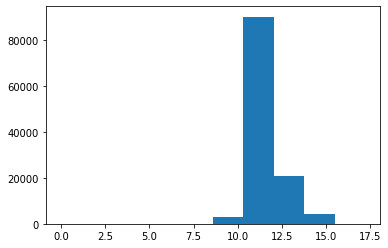

In [8]:
plt.hist(transformed_bindings.stack())

### 1.4 Drug-Target-Binding

In [9]:
drug_target_binding = transformed_bindings.copy()
drug_target_binding.index.name = 'Drug'
drug_target_binding.reset_index(level=0, inplace=True)
drug_target_binding = drug_target_binding.melt(id_vars='Drug', value_vars=transformed_bindings.columns, var_name='Target', value_name='Binding_Val')


print(drug_target_binding.shape)
drug_target_binding.head()

(483419, 3)


,Drug,Target,Binding_Val
0,CHEMBL100102,O00141,NaN
1,CHEMBL101311,O00141,NaN
2,CHEMBL101683,O00141,NaN
3,CHEMBL102301,O00141,NaN
4,CHEMBL102346,O00141,NaN


### 1.5 Train, Validation and Test Datasets

In [10]:
idx = np.random.permutation(drug_target_binding.index)
train_data = drug_target_binding.iloc[idx[:int(drug_target_binding.shape[0] * 0.66)], :]
val_data = drug_target_binding.iloc[idx[int(drug_target_binding.shape[0] * 0.66):int(drug_target_binding.shape[0] * 0.83)], :]
test_data = drug_target_binding.iloc[idx[int(drug_target_binding.shape[0] * 0.83):], :]

train_data.shape, val_data.shape, test_data.shape

((319056, 3), (82181, 3), (82182, 3))

## 2.Feature Engineering

### 2.1 Average Similarities and Binding values

In [11]:
target_gene_names['avg_sim_target'] = sim_targets.mean()
target_gene_names['avg_binding_target'] = train_data.groupby('Target')['Binding_Val'].mean()

target_gene_names.head()

,avg_sim_target,avg_binding_target
O00141,0.134447,12.527256
O00311,0.073043,12.550373
O00329,0.053694,11.518352
O00418,0.052828,12.005535
O00444,0.089390,11.456073


In [12]:
drug_pubchemIDs['avg_sim_drug'] = sim_drugs.mean()
drug_pubchemIDs['avg_binding_drug'] = train_data.groupby('Drug')['Binding_Val'].mean()

drug_pubchemIDs.head()

,avg_sim_drug,avg_binding_drug
CHEMBL100102,0.549030,10.473713
CHEMBL101311,0.539323,11.753583
CHEMBL101683,0.577842,12.254947
CHEMBL102301,0.546228,10.794309
CHEMBL102346,0.558180,11.096799


### 2.2 Drug/Target Similarity Networks

#### 2.2.1 Build Networks

In [13]:
!pip install python-igraph
import igraph

In [14]:
import scipy

drug_sim_threshold = 0.7
target_sim_threshold = 0.05
p_value_threshold = 0.05

drug_adj_matrix = sim_drugs.values
drug_z_scores = scipy.stats.zscore(drug_adj_matrix)
drug_p_values = scipy.stats.norm.sf(abs(drug_z_scores))
drug_adj_matrix = (drug_p_values < p_value_threshold)
np.fill_diagonal(drug_adj_matrix, False)
drug_graph = igraph.Graph.Adjacency(drug_adj_matrix.tolist(), mode=1)
drug_graph.vs['label'] = sim_drugs.index.to_list()


target_adj_matrix = sim_targets.values
target_z_scores = scipy.stats.zscore(target_adj_matrix)
target_p_values = scipy.stats.norm.sf(abs(target_z_scores))
target_adj_matrix = (target_p_values < p_value_threshold)
np.fill_diagonal(target_adj_matrix, False)
target_graph = igraph.Graph.Adjacency(target_adj_matrix.tolist(), mode=1)
target_graph.vs['label'] = sim_drugs.index.to_list()


#### 2.2.2 Number of neighbors, PageRank

In [15]:
drug_pubchemIDs['page_rank_drug'] = drug_graph.pagerank()
drug_neighbors = [0] * drug_pubchemIDs.shape[0]
for i in range(drug_pubchemIDs.shape[0]):
  drug_neighbors[i] = len(drug_graph.neighbors(i))
drug_pubchemIDs['n_neighbors_drug'] = drug_neighbors

target_gene_names['page_rank_target'] = target_graph.pagerank()
target_neighbors = [0] * target_gene_names.shape[0]
for i in range(target_gene_names.shape[0]):
  target_neighbors[i] = len(target_graph.neighbors(i))
target_gene_names['n_neighbors_target'] = target_neighbors

### 2.3 Non-negative Matrix Factorization

In [16]:
from sklearn.decomposition import NMF

In [17]:
latent_dim = 9
train_binding_matrix = train_data.pivot(index='Drug', columns='Target', values='Binding_Val')
train_binding_matrix.fillna(10.0, inplace=True)

train_binding_matrix.head()

Target,O00141,O00311,O00329,O00418,O00444,O14757,O14920,O14965,O15075,O15111,...,Q9UGI9,Q9UGJ0,Q9UHD2,Q9UM73,Q9UQM7,Q9Y243,Q9Y463,Q9Y478,Q9Y4K4,Q9Y6M4
Drug,,,,,,,,,,,,,,,,,,,,,
CHEMBL100102,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.000000,...,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.0,10.0
CHEMBL101311,10.0,10.0,10.0,10.0,10.0,10.0,11.900001,10.0,10.0,10.000000,...,10.0,10.0,10.0,11.5,10.0,11.699999,10.0,10.0,10.0,10.0
CHEMBL101683,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.000000,...,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.0,10.0
CHEMBL102301,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.622879,...,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.0,10.0
CHEMBL102346,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.000000,...,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0,10.0,10.0


In [18]:
model = NMF(n_components=latent_dim, init='random', random_state=0)
P = model.fit_transform(train_binding_matrix)
Q = model.components_

Q_columns = [('target' + str(i)) for i in range(latent_dim)]
P_columns = [('drug' + str(i)) for i in range(latent_dim)]

target_gene_names = pd.concat([target_gene_names, pd.DataFrame(Q.T, index=target_gene_names.index, columns=Q_columns)], axis=1)
drug_pubchemIDs = pd.concat([drug_pubchemIDs, pd.DataFrame(P, index=drug_pubchemIDs.index, columns=P_columns)], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [19]:
drug_pubchemIDs

,avg_sim_drug,avg_binding_drug,page_rank_drug,n_neighbors_drug,drug0,drug1,drug2,drug3,drug4,drug5,drug6,drug7,drug8
CHEMBL100102,0.549030,10.473713,0.000373,278,2.979629,1.274235,1.326210,0.737880,1.278313,1.071851,0.880810,0.879200,0.979122
CHEMBL101311,0.539323,11.753583,0.000326,243,2.903296,1.048296,1.198986,1.296538,0.862400,0.750833,1.644296,0.708665,1.249598
CHEMBL101683,0.577842,12.254947,0.000406,316,2.946552,1.131867,1.031746,1.078806,1.178794,1.116228,0.651238,0.983853,1.291307
CHEMBL102301,0.546228,10.794309,0.000343,258,2.950635,1.325176,1.375365,0.849490,1.216605,0.898332,0.823696,0.907061,1.140882
CHEMBL102346,0.558180,11.096799,0.000387,297,3.051742,1.290293,1.317854,0.863906,1.215752,0.972357,0.719026,0.935732,1.110058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL97822,0.565832,12.359637,0.000374,282,2.920280,1.093792,1.549658,0.559855,1.108117,1.300479,1.093442,0.829662,0.955978
CHEMBL98350,0.542532,11.308956,0.001210,1016,3.025748,1.453659,1.212570,0.781353,1.349501,0.924837,0.725577,0.940453,1.097950
CHEMBL98721,0.565832,10.534072,0.000460,365,2.980688,1.284335,1.345979,0.728519,1.299993,1.073651,0.879217,0.851274,0.981091
CHEMBL99572,0.546784,10.664737,0.000351,267,2.963594,1.277321,1.404928,0.686658,1.235208,1.127725,0.888324,0.880639,0.944635


In [20]:
target_gene_names

,avg_sim_target,avg_binding_target,page_rank_target,n_neighbors_target,target0,target1,target2,target3,target4,target5,target6,target7,target8
O00141,0.134447,12.527256,0.005467,12,1.907748,0.414884,0.000000,1.312456,0.838867,0.909562,0.893679,0.000000,0.000000
O00311,0.073043,12.550373,0.000725,0,0.262683,1.377240,0.488118,0.374856,1.703369,0.981649,0.687519,1.122246,1.884982
O00329,0.053694,11.518352,0.004833,3,0.731289,0.717917,0.543571,0.709450,1.292050,1.062906,1.088630,1.507670,0.581223
O00418,0.052828,12.005535,0.000725,0,1.557588,0.398897,0.881963,1.016932,0.089559,0.895606,0.178299,1.172709,0.609348
O00444,0.089390,11.456073,0.000725,0,1.021485,0.617416,0.930226,0.917879,0.623452,0.660482,1.280923,1.225305,0.706846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y243,0.135203,11.914726,0.008361,19,0.755541,0.408635,0.835018,0.860803,1.285220,0.173651,1.781528,1.014535,1.231206
Q9Y463,0.094262,11.388574,0.004833,3,0.832557,0.655894,0.699033,0.282609,1.149589,0.897302,0.903218,1.086719,1.367741
Q9Y478,0.052215,11.955944,0.004833,1,0.477888,1.688243,0.864461,2.113419,0.779640,1.482929,0.888692,0.210149,0.101467
Q9Y4K4,0.087644,11.503821,0.004089,3,0.363139,0.822866,1.054538,1.562669,1.394815,1.460719,1.048148,1.105308,0.090524


### 2.4 Building Train, Validation and Test Dataset using extracted features

In [21]:
train_data = train_data.dropna(axis=0)

In [22]:
test_data = test_data.dropna(axis=0)

In [23]:
val_data = val_data.dropna(axis=0)

In [24]:
X_train = pd.DataFrame(columns= target_gene_names.columns.to_list() + drug_pubchemIDs.columns.to_list(), index=train_data.index)
Y_train = train_data['Binding_Val']
for i in X_train.index:
  X_train.loc[i] = drug_pubchemIDs.loc[train_data.loc[i]['Drug']].append(target_gene_names.loc[train_data.loc[i]['Target']])

X_val = pd.DataFrame(columns= target_gene_names.columns.to_list() + drug_pubchemIDs.columns.to_list(), index=val_data.index)
Y_val = val_data['Binding_Val']
for i in X_val.index:
  X_val.loc[i] = drug_pubchemIDs.loc[val_data.loc[i]['Drug']].append(target_gene_names.loc[val_data.loc[i]['Target']])

X_test = pd.DataFrame(columns= target_gene_names.columns.to_list() + drug_pubchemIDs.columns.to_list(), index=test_data.index)
Y_test = test_data['Binding_Val']
for i in X_test.index:
  X_test.loc[i] = drug_pubchemIDs.loc[test_data.loc[i]['Drug']].append(target_gene_names.loc[test_data.loc[i]['Target']])

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((77993, 26), (77993,), (20213, 26), (20213,), (19963, 26), (19963,))

## 3.XGboost

In [25]:
!pip install xgboost
import xgboost
from sklearn.metrics import mean_squared_error

### 3.1 Tune Hyperparameters

In [26]:
def plot_model_results(results):
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.show()

In [27]:
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

Validation RMSE: 0.277


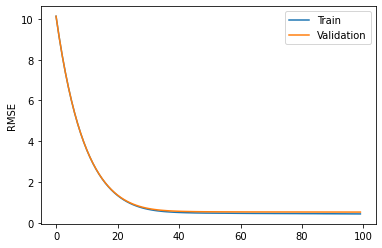

In [28]:
import pickle

learning_rate = 0.1
n_estimators = 100
max_depth = 8
colsample_bytree = 1
subsample = 1

model = xgboost.XGBRegressor(objective ='reg:squarederror', 
                             learning_rate = learning_rate, 
                             colsample_bytree = colsample_bytree,
                             max_depth = max_depth, 
                             subsample = subsample, 
                             n_estimators = n_estimators,
                             eval_metric='rmse')

model.fit(X_train, Y_train, 
          eval_set=[(X_train, Y_train), (X_val, Y_val)], 
          verbose=False)

validation_rmse = mean_squared_error(Y_val, model.predict(X_val))
print("Validation RMSE: %.3f" % validation_rmse)
plot_model_results(model.evals_result())
pickle.dump(model, open('kiba_simboost.pkl', 'wb'))

### 3.2 Evaluation

In [29]:
import tensorflow as tf
def cindex_score(y_true, y_pred):

    g = tf.subtract(tf.expand_dims(y_pred, -1), y_pred)
    g = tf.cast(g == 0.0, tf.float32) * 0.5 + tf.cast(g > 0.0, tf.float32)

    f = tf.subtract(tf.expand_dims(y_true, -1), y_true) > 0.0
    f = tf.compat.v1.matrix_band_part(tf.cast(f, tf.float32), -1, 0)

    g = tf.reduce_sum(tf.multiply(g, f))
    f = tf.reduce_sum(f)

    return tf.where(tf.equal(g, 0), 0.0, g/f) #select

In [30]:
import pickle
loaded_model = pickle.load(open('kiba_simboost.pkl', 'rb'))
Y_pred = loaded_model.predict(X_test)

print("KIBA Test CI-Index: %.3f" % cindex_score(Y_test, Y_pred))
print("KIBA Test MSE: %.3f" % mean_squared_error(Y_test, Y_pred))

KIBA Test CI-Index: 0.824
KIBA Test MSE: 0.279
